In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.models import Sequential, load_model
from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.python.keras.layers import SimpleRNN, LSTM
from tensorflow.python.keras.layers import Embedding, Masking
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

import sklearn
from sklearn.impute import SimpleImputer as imputer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import glob
import os
import shutil
import csv
import timeit


from matplotlib import style
style.use('ggplot') or plt.style.use('ggplot')
from driver import stack_list, stack_labels, return_shapes, return_to_original, split_probs

# %matplotlib inline
# %config InlineBackend.figure_format='retina'

In [2]:
def return_original_values(data, shapes):
    result = []
    
    for i,k in enumerate(shapes):
        temp = data[i]
        result.append(temp[0:k])
        
    return np.array(result)

In [3]:
df_list = []
labels = []

for f in sorted(glob.glob("training/" + "/*.psv")):
    df_list.append(pd.read_csv(f,sep='|'))
    labels.append(df_list[len(df_list)-1]["SepsisLabel"])
    

#Making sure that imputation does not removes the EtC02 column
#Also removing the sepsislable column from the original data
for i in df_list:
    i.iloc[0,i.columns.get_loc('EtCO2')] = 0
    i.drop('SepsisLabel', axis=1, inplace=True)
    
    
df_list2 = []
labels2 = []

for f in sorted(glob.glob("training_setB/" + "/*.psv")):
    df_list2.append(pd.read_csv(f,sep='|'))
    labels2.append(df_list2[len(df_list2)-1]["SepsisLabel"])
    
    
for i in df_list2:
    i.drop('SepsisLabel', axis=1 , inplace=True)

In [4]:
test_shapes = return_shapes(df_list2)

#Padding the train and test values for LSTM input with zero
x_train = tf.keras.preprocessing.sequence.pad_sequences(df_list,padding="post", dtype='float64' ,value = 0)
y_train = tf.keras.preprocessing.sequence.pad_sequences(labels,padding="post",dtype='float64' , value = 0)
x_test = tf.keras.preprocessing.sequence.pad_sequences(df_list2,padding="post",dtype='float64' , value = 0)
y_test = tf.keras.preprocessing.sequence.pad_sequences(labels2,padding="post",dtype='float64' , value = 0)

x_train[x_train <0] = 0
x_test[x_test <0] = 0


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less
  # Remove the CWD from sys.path while we load stuff.


In [5]:
#Normalizing the dataset.
# NOTE: CHANGE THIS TO BEFORE PADDING

print(x_train.shape)
print(y_train.shape)

x_train = tf.keras.utils.normalize(x_train, axis=0, order=2)
x_test = tf.keras.utils.normalize(x_test, axis=0, order=2)

print(x_train.shape)
print(y_train.shape)

(20336, 336, 40)
(20336, 336)
(20336, 336, 40)
(20336, 336)


In [55]:
batch_size = 128
input_dim = x_test.shape[2]
output_size = 2
units = 64


model = keras.Sequential()

model.add(keras.layers.Reshape((336*40,), input_shape=(336,40)))
model.add(keras.layers.Embedding(input_dim= (336*40)+1,
                                 output_dim=1,
                                 input_length=336 * 40, mask_zero = True))

model.add(keras.layers.Reshape((336, 40,)))

model.add(LSTM(units= 150, return_sequences = True, input_shape =(x_test.shape[-2:])))
model.add(Dropout(0.3))


model.add(LSTM(units= 75, return_sequences = True))
model.add(Dropout(0.2))


model.add(LSTM(units= 50, return_sequences= True))
model.add(Dropout(0.1))


model.add(Dense(1,activation = 'sigmoid'))

model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_24 (Reshape)         (None, 13440)             0         
_________________________________________________________________
embedding_12 (Embedding)     (None, 13440, 1)          13441     
_________________________________________________________________
reshape_25 (Reshape)         (None, 336, 40)           0         
_________________________________________________________________
lstm_35 (LSTM)               (None, 336, 150)          114600    
_________________________________________________________________
dropout_34 (Dropout)         (None, 336, 150)          0         
_________________________________________________________________
lstm_36 (LSTM)               (None, 336, 75)           67800     
_________________________________________________________________
dropout_35 (Dropout)         (None, 336, 75)         

In [56]:

model.compile(loss=keras.losses.categorical_crossentropy,optimizer='Adamax',metrics=["accuracy"],)


# model.compile(optimizer='adamax',loss='mean_squared_error',metrics=['accuracy'])

x_trn, xval, y_trn, yval = train_test_split(x_train,y_train, test_size= 0.2)

history = model.fit(x_trn, y_trn,batch_size=batch_size, epochs=3,verbose=1, validation_data = (xval,yval))


Train on 16268 samples, validate on 4068 samples
Epoch 1/3
16268/16268 [==============================] - 366s 22ms/sample - loss: 3.6532 - accuracy: 0.9466 - val_loss: 3.4995 - val_accuracy: 0.9526
Epoch 2/3
16268/16268 [==============================] - 351s 22ms/sample - loss: 3.2030 - accuracy: 0.9472 - val_loss: 3.3998 - val_accuracy: 0.9576
Epoch 3/3
16268/16268 [==============================] - 359s 22ms/sample - loss: 3.1113 - accuracy: 0.9614 - val_loss: 3.2874 - val_accuracy: 0.9679


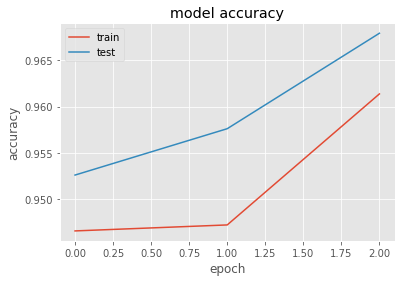

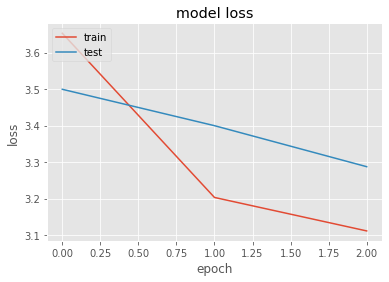

In [57]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [58]:
x_test = np.array(x_test, 'float64')
predicted_probability = model.predict(x_test)
predicted_classes =  model.predict_classes(x_test)



In [59]:
print(predicted_probability.shape)
probabilities = [np.reshape(a,(a.shape[:-1])) for a in predicted_probability]
probabilities = return_original_values(probabilities,test_shapes).tolist()
print(probabilities[1].shape)
print(probabilities[1])
print(predicted_probability[2,:,:])

(20000, 336, 1)
(25,)
[0.42786044 0.38562322 0.35521936 0.33035067 0.30928767 0.29313642
 0.28220934 0.28126228 0.2859438  0.2948492  0.3085709  0.32622564
 0.34270793 0.36283922 0.3882105  0.41406572 0.44219077 0.4722049
 0.4943807  0.51040906 0.51916826 0.52779996 0.5394624  0.5555029
 0.5801411 ]
[[4.2515543e-01]
 [3.7336704e-01]
 [3.2638896e-01]
 [2.8116354e-01]
 [2.3648345e-01]
 [2.0306551e-01]
 [1.8256947e-01]
 [1.6579801e-01]
 [1.4720967e-01]
 [1.2965837e-01]
 [1.1168015e-01]
 [9.2504054e-02]
 [7.5643808e-02]
 [6.6186398e-02]
 [6.4814329e-02]
 [7.1229488e-02]
 [8.6223304e-02]
 [1.0948643e-01]
 [1.4446595e-01]
 [1.9012100e-01]
 [2.4091539e-01]
 [2.9284140e-01]
 [3.3883065e-01]
 [3.7895536e-01]
 [4.1337746e-01]
 [4.4358924e-01]
 [4.6946585e-01]
 [4.9266997e-01]
 [5.1791066e-01]
 [5.4355967e-01]
 [5.6784165e-01]
 [5.8759868e-01]
 [6.0799670e-01]
 [6.2583673e-01]
 [6.4095300e-01]
 [6.4952326e-01]
 [6.4891148e-01]
 [6.4390236e-01]
 [6.3771838e-01]
 [6.2493879e-01]
 [6.0628128e-01]
 [

In [60]:
print('Predicted classes is an ARRAY with a shape of: {}'.format(predicted_classes.shape))
data = [np.reshape(a,(a.shape[:-1])) for a in predicted_classes]
print('Now we reshape predict classes, and now its a LIST with the length: {}'.format(len(data))) 
print('First element in the reshaped version has the shape of: {}'.format(data[1].shape))

print('*************** RETURN TO ORIGINAL ***************')

data = return_original_values(np.array(data),test_shapes)
print('Returned to original version has the length of: {}'.format(len(data)))
print('Returned to original versions first element has the shape of: {}'.format(data[1].shape))

predicted_labels = data.tolist()
print(predicted_labels[12])
print(y_test[12][0:predicted_labels[12].size])

Predicted classes is an ARRAY with a shape of: (20000, 336, 1)
Now we reshape predict classes, and now its a LIST with the length: 20000
First element in the reshaped version has the shape of: (336,)
*************** RETURN TO ORIGINAL ***************
Returned to original version has the length of: 20000
Returned to original versions first element has the shape of: (25,)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]


In [61]:
#Writing files to a directory under predictions
output_directory = "predictions"
if os.path.exists(output_directory):
    shutil.rmtree(output_directory)
    os.mkdir(output_directory)
else: 
    os.mkdir(output_directory)

for i,f in enumerate(predicted_labels):
    with open('predictions/p1%05d.psv' % i, 'w') as f:
        f.write('PredictedProbability|PredictedLabel\n')
        for(s,l) in zip(probabilities[i],predicted_labels[i]):
            f.write('%g|%d\n' % (s,l))
            
            
            
import datetime
print(datetime.datetime.now())
print('Done ...')

2020-08-13 22:02:59.786680
Done ...
